In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import numpy as np


In [3]:
# Ruta base donde están TACO y TrashNet
data_dir = r"C:\Users\soria\Downloads\Metodología\Clasificacion_residuos"

# Carpeta nueva para guardar los modelos de esta versión con splits
os.makedirs("Modelos2", exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)


Usando dispositivo: cpu


In [5]:
# Transformaciones para entrenamiento
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Transformaciones para validación y prueba
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [9]:
def cargar_y_dividir_dataset(ruta_carpeta, seed=42):
    """
    Carga un dataset tipo ImageFolder y lo divide en 70% train, 15% val, 15% test
    sin modificar las carpetas físicas.
    """
    # cargamos TODO con las transfos de train
    full_dataset = datasets.ImageFolder(ruta_carpeta, transform=train_transforms)
    total = len(full_dataset)

    train_size = int(0.7 * total)
    val_size = int(0.15 * total)
    test_size = total - train_size - val_size

    torch.manual_seed(seed)
    train_ds, val_ds, test_ds = random_split(full_dataset, [train_size, val_size, test_size])

    # a val y test les cambiamos transform
    val_ds.dataset.transform = val_test_transforms
    test_ds.dataset.transform = val_test_transforms

    # dataloaders
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

    class_names = full_dataset.classes

    print(f"  Total: {total}")
    print(f"  Train: {len(train_ds)}")
    print(f"  Val:   {len(val_ds)}")
    print(f"  Test:  {len(test_ds)}")
    print(f"  Clases: {class_names}")

    return {
        "train": train_loader,
        "val": val_loader,
        "test": test_loader
    }, class_names


In [11]:
def crear_modelo_resnet18(num_classes):
    model = models.resnet18(weights="IMAGENET1K_V1")
    # congelamos al inicio (fase 1)
    for p in model.parameters():
        p.requires_grad = False
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    model = model.to(device)
    return model


In [13]:
def train_model(model, criterion, optimizer, dataloaders, dataset_sizes, escenario="Sx", num_epochs=10):
    best_acc = 0.0
    best_wts = model.state_dict()

    print(f"\n Iniciando entrenamiento escenario {escenario}")
    for epoch in range(num_epochs):
        print(f"\nÉpoca {epoch+1}/{num_epochs}")
        print("-" * 30)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase.upper():<5} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")

            # guardar mejor modelo según val
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_wts = model.state_dict()

    # cargar mejor modelo
    model.load_state_dict(best_wts)

    # guardar modelo en carpeta nueva
    model_path = f"Modelos2/resnet18_{escenario}.pth"
    torch.save(model.state_dict(), model_path)
    print(f"\n Mejor modelo del escenario {escenario} guardado en: {model_path}")
    print(f" Mejor accuracy de validación: {best_acc:.4f}")

    return model


In [15]:
def evaluar_en_test(model, test_loader, class_names, escenario="Sx_test"):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    print(f"\n Evaluación en TEST para {escenario}")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    cm = confusion_matrix(y_true, y_pred)
    # matriz sin seaborn
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(cm, cmap="Blues")
    ax.figure.colorbar(im, ax=ax)
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.set_yticklabels(class_names)
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Real")
    ax.set_title(f"Matriz de confusión - {escenario}")
    # números
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j],
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()

    return acc


  Total: 2499
  Train: 1749
  Val:   374
  Test:  376
  Clases: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

 Iniciando entrenamiento escenario S0_split

Época 1/10
------------------------------
TRAIN | Loss: 1.3256 | Acc: 0.5106
VAL   | Loss: 0.9997 | Acc: 0.6578

Época 2/10
------------------------------
TRAIN | Loss: 0.8444 | Acc: 0.7284
VAL   | Loss: 0.7763 | Acc: 0.7246

Época 3/10
------------------------------
TRAIN | Loss: 0.7364 | Acc: 0.7530
VAL   | Loss: 0.6842 | Acc: 0.7781

Época 4/10
------------------------------
TRAIN | Loss: 0.6313 | Acc: 0.7885
VAL   | Loss: 0.6591 | Acc: 0.7727

Época 5/10
------------------------------
TRAIN | Loss: 0.5718 | Acc: 0.8102
VAL   | Loss: 0.6115 | Acc: 0.7968

Época 6/10
------------------------------
TRAIN | Loss: 0.5529 | Acc: 0.8130
VAL   | Loss: 0.5848 | Acc: 0.8048

Época 7/10
------------------------------
TRAIN | Loss: 0.5049 | Acc: 0.8285
VAL   | Loss: 0.5749 | Acc: 0.8048

Época 8/10
---------------------------

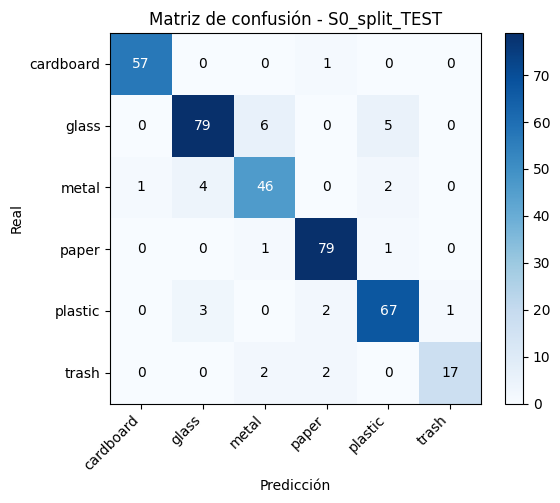

Accuracy final en TEST (S0): 0.9175531914893617


In [17]:
# ========= ESCENARIO S0 (con splits 70/15/15) =========
loaders_trash, class_names = cargar_y_dividir_dataset(os.path.join(data_dir, "TrashNet"))

dataloaders = {
    'train': loaders_trash['train'],
    'val': loaders_trash['val']
}
dataset_sizes = {
    'train': len(loaders_trash['train'].dataset),
    'val': len(loaders_trash['val'].dataset)
}

model = crear_modelo_resnet18(num_classes=len(class_names))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Fase 1
model = train_model(model, criterion, optimizer, dataloaders, dataset_sizes, escenario="S0_split", num_epochs=10)

# Fase 2: fine-tuning
for p in model.parameters():
    p.requires_grad = True
optimizer = optim.Adam(model.parameters(), lr=1e-4)
model = train_model(model, criterion, optimizer, dataloaders, dataset_sizes, escenario="S0_split_finetuned", num_epochs=10)

# Evaluación en TEST (el 15% que no vio)
test_acc = evaluar_en_test(model, loaders_trash['test'], class_names, escenario="S0_split_TEST")
print("Accuracy final en TEST (S0):", test_acc)


In [19]:
#ESCENARIO S1
loaders_taco, class_names = cargar_y_dividir_dataset(
    os.path.join(data_dir, "TACO")
)


  Total: 4374
  Train: 3061
  Val:   656
  Test:  657
  Clases: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [21]:
model = crear_modelo_resnet18(num_classes=len(class_names))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


In [23]:
dataloaders = {
    'train': loaders_taco['train'],
    'val': loaders_taco['val']
}
dataset_sizes = {
    'train': len(loaders_taco['train'].dataset),
    'val': len(loaders_taco['val'].dataset)
}


In [25]:
# Fase 1: entrenamiento de la capa final
model = train_model(model, criterion, optimizer, dataloaders, dataset_sizes,
                    escenario="S1_split", num_epochs=10)

# Fase 2: fine-tuning (descongelar todas las capas)
for p in model.parameters():
    p.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=1e-4)
model = train_model(model, criterion, optimizer, dataloaders, dataset_sizes,
                    escenario="S1_split_finetuned", num_epochs=10)



 Iniciando entrenamiento escenario S1_split

Época 1/10
------------------------------
TRAIN | Loss: 1.3372 | Acc: 0.5051
VAL   | Loss: 1.1007 | Acc: 0.6204

Época 2/10
------------------------------
TRAIN | Loss: 1.0983 | Acc: 0.6076
VAL   | Loss: 1.0455 | Acc: 0.6326

Época 3/10
------------------------------
TRAIN | Loss: 1.0088 | Acc: 0.6377
VAL   | Loss: 0.9890 | Acc: 0.6479

Época 4/10
------------------------------
TRAIN | Loss: 0.9669 | Acc: 0.6527
VAL   | Loss: 0.9640 | Acc: 0.6418

Época 5/10
------------------------------
TRAIN | Loss: 0.9403 | Acc: 0.6576
VAL   | Loss: 0.9488 | Acc: 0.6509

Época 6/10
------------------------------
TRAIN | Loss: 0.9112 | Acc: 0.6746
VAL   | Loss: 0.9592 | Acc: 0.6418

Época 7/10
------------------------------
TRAIN | Loss: 0.9017 | Acc: 0.6681
VAL   | Loss: 0.9231 | Acc: 0.6799

Época 8/10
------------------------------
TRAIN | Loss: 0.8782 | Acc: 0.6707
VAL   | Loss: 0.9444 | Acc: 0.6555

Época 9/10
------------------------------
TRAIN | 


 Evaluación en TEST para S1_split_TEST
Accuracy: 0.6667
              precision    recall  f1-score   support

   cardboard     0.6087    0.4242    0.5000        33
       glass     0.4590    0.7000    0.5545        40
       metal     0.5444    0.6901    0.6087        71
       paper     0.2000    0.2273    0.2128        22
     plastic     0.8000    0.6797    0.7350       306
       trash     0.6768    0.7243    0.6997       185

    accuracy                         0.6667       657
   macro avg     0.5482    0.5743    0.5518       657
weighted avg     0.6872    0.6667    0.6711       657



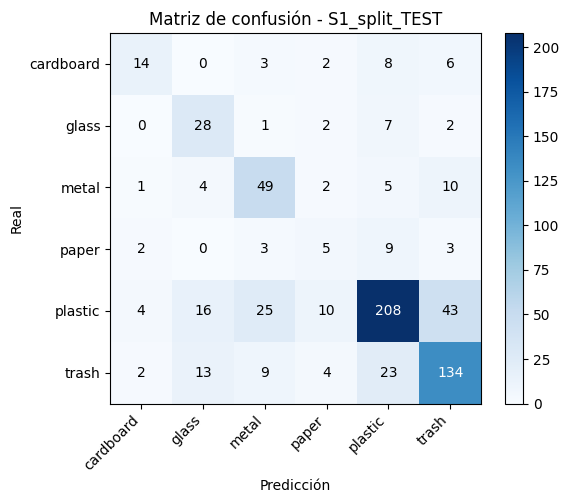

Accuracy final en TEST (S1): 0.6666666666666666


In [27]:
test_acc = evaluar_en_test(model, loaders_taco['test'], class_names, escenario="S1_split_TEST")
print("Accuracy final en TEST (S1):", test_acc)


In [29]:
# === ESCENARIO S2 ===
loaders_trash, class_names = cargar_y_dividir_dataset(os.path.join(data_dir, "TrashNet"))
loaders_taco, _ = cargar_y_dividir_dataset(os.path.join(data_dir, "TACO"))


  Total: 2499
  Train: 1749
  Val:   374
  Test:  376
  Clases: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
  Total: 4374
  Train: 3061
  Val:   656
  Test:  657
  Clases: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [31]:
dataloaders = {
    'train': loaders_trash['train'],
    'val': loaders_taco['val']
}
dataset_sizes = {
    'train': len(loaders_trash['train'].dataset),
    'val': len(loaders_taco['val'].dataset)
}


In [33]:
model = crear_modelo_resnet18(num_classes=len(class_names))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


In [35]:
# Fase 1: solo capa final
model = train_model(model, criterion, optimizer, dataloaders, dataset_sizes,
                    escenario="S2_split", num_epochs=10)

# Fase 2: fine-tuning
for p in model.parameters():
    p.requires_grad = True
optimizer = optim.Adam(model.parameters(), lr=1e-4)
model = train_model(model, criterion, optimizer, dataloaders, dataset_sizes,
                    escenario="S2_split_finetuned", num_epochs=10)



 Iniciando entrenamiento escenario S2_split

Época 1/10
------------------------------
TRAIN | Loss: 1.3222 | Acc: 0.5369
VAL   | Loss: 2.1140 | Acc: 0.1555

Época 2/10
------------------------------
TRAIN | Loss: 0.8434 | Acc: 0.7204
VAL   | Loss: 2.1324 | Acc: 0.2180

Época 3/10
------------------------------
TRAIN | Loss: 0.7069 | Acc: 0.7639
VAL   | Loss: 2.1516 | Acc: 0.2073

Época 4/10
------------------------------
TRAIN | Loss: 0.6358 | Acc: 0.7965
VAL   | Loss: 2.1555 | Acc: 0.2210

Época 5/10
------------------------------
TRAIN | Loss: 0.5925 | Acc: 0.7913
VAL   | Loss: 2.1925 | Acc: 0.2180

Época 6/10
------------------------------
TRAIN | Loss: 0.5526 | Acc: 0.8210
VAL   | Loss: 2.0442 | Acc: 0.2652

Época 7/10
------------------------------
TRAIN | Loss: 0.5249 | Acc: 0.8216
VAL   | Loss: 2.5246 | Acc: 0.2165

Época 8/10
------------------------------
TRAIN | Loss: 0.4734 | Acc: 0.8416
VAL   | Loss: 2.2370 | Acc: 0.2409

Época 9/10
------------------------------
TRAIN | 


 Evaluación en TEST para S2_split_TEST
Accuracy: 0.1918
              precision    recall  f1-score   support

   cardboard     0.1765    0.5455    0.2667        33
       glass     0.1037    0.3500    0.1600        40
       metal     0.1754    0.5634    0.2676        71
       paper     0.0444    0.1818    0.0714        22
     plastic     0.5341    0.1536    0.2386       306
       trash     0.2143    0.0162    0.0302       185

    accuracy                         0.1918       657
   macro avg     0.2081    0.3017    0.1724       657
weighted avg     0.3447    0.1918    0.1741       657



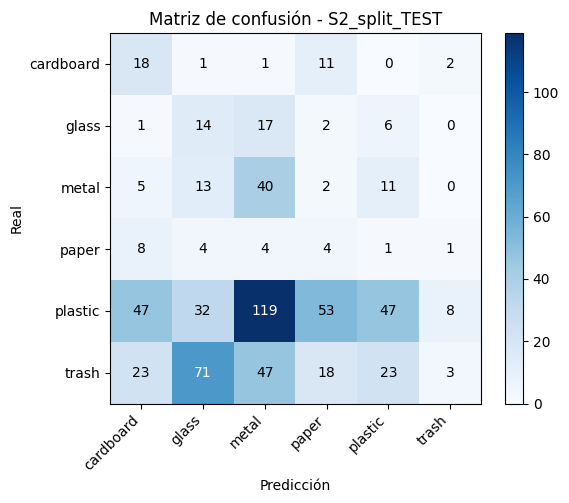

Accuracy final en TEST (S2): 0.1917808219178082


In [37]:
test_acc = evaluar_en_test(model, loaders_taco['test'], class_names, escenario="S2_split_TEST")
print("Accuracy final en TEST (S2):", test_acc)


  Total: 4374
  Train: 3061
  Val:   656
  Test:  657
  Clases: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
  Total: 2499
  Train: 1749
  Val:   374
  Test:  376
  Clases: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

 Iniciando entrenamiento escenario S3_split

Época 1/10
------------------------------
TRAIN | Loss: 1.2959 | Acc: 0.5413
VAL   | Loss: 1.1249 | Acc: 0.6067

Época 2/10
------------------------------
TRAIN | Loss: 1.0712 | Acc: 0.6165
VAL   | Loss: 1.0245 | Acc: 0.6494

Época 3/10
------------------------------
TRAIN | Loss: 1.0013 | Acc: 0.6361
VAL   | Loss: 1.0149 | Acc: 0.6418

Época 4/10
------------------------------
TRAIN | Loss: 0.9681 | Acc: 0.6488
VAL   | Loss: 0.9719 | Acc: 0.6387

Época 5/10
------------------------------
TRAIN | Loss: 0.9309 | Acc: 0.6553
VAL   | Loss: 0.9572 | Acc: 0.6585

Época 6/10
------------------------------
TRAIN | Loss: 0.9000 | Acc: 0.6694
VAL   | Loss: 0.9335 | Acc: 0.6723

Época 7/10
---------------

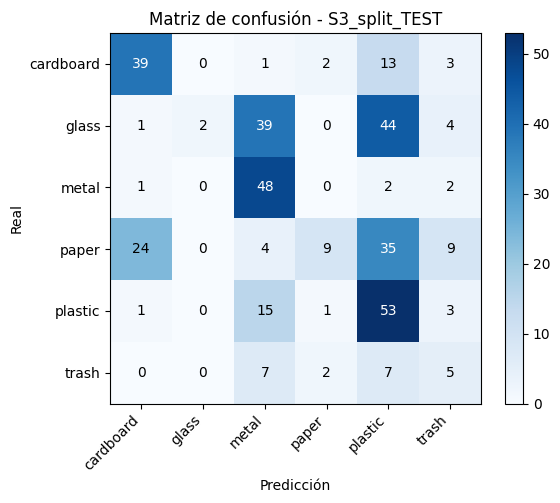

Accuracy final en TEST (S3): 0.4148936170212766


In [39]:
# ESCENARIO S3
# Train/val en TACO, test en TrashNet

# 1. Cargamos y dividimos ambos datasets
loaders_taco, class_names = cargar_y_dividir_dataset(os.path.join(data_dir, "TACO"))
loaders_trash, _ = cargar_y_dividir_dataset(os.path.join(data_dir, "TrashNet"))

# 2. Preparamos los dataloaders para este escenario
dataloaders = {
    'train': loaders_taco['train'],   # entrenamos en TACO
    'val': loaders_taco['val']        # validamos también en TACO
}
dataset_sizes = {
    'train': len(loaders_taco['train'].dataset),
    'val': len(loaders_taco['val'].dataset)
}

# 3. Creamos el modelo
model = crear_modelo_resnet18(num_classes=len(class_names))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# 4. Fase 1: entrenar solo la capa final
model = train_model(
    model,
    criterion,
    optimizer,
    dataloaders,
    dataset_sizes,
    escenario="S3_split",
    num_epochs=10
)

# 5. Fase 2: fine-tuning (descongelamos todo)
for p in model.parameters():
    p.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=1e-4)

model = train_model(
    model,
    criterion,
    optimizer,
    dataloaders,
    dataset_sizes,
    escenario="S3_split_finetuned",
    num_epochs=10
)

# 6. Evaluación en TEST: ahora sí probamos en TrashNet
test_acc = evaluar_en_test(
    model,
    loaders_trash['test'], 
    class_names,
    escenario="S3_split_TEST"
)
print("Accuracy final en TEST (S3):", test_acc)


=== Comparativa de Accuracy en escenarios intra-dominio ===

Escenario                             Accuracy Test
-------------------------------------------------------
S0 (TrashNet→TrashNet)                       0.9175
S1 (TACO→TACO)                               0.6666




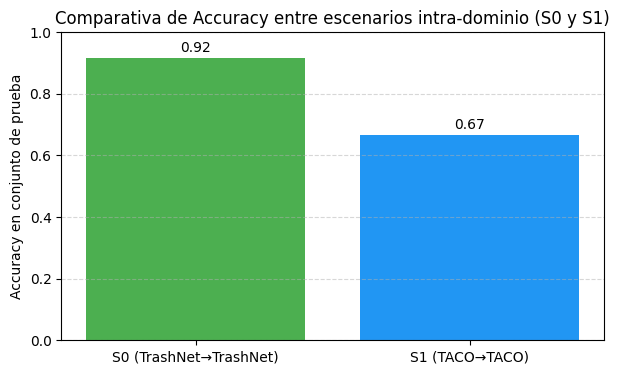

In [43]:
import matplotlib.pyplot as plt

# === Resultados directos (ajústalos si tus valores finales fueron distintos) ===
escenarios = ["S0 (TrashNet→TrashNet)", "S1 (TACO→TACO)"]
accuracies = [0.9175, 0.6666]
descripciones = [
    "Entrenamiento y prueba dentro del dominio controlado (TrashNet)",
    "Entrenamiento y prueba dentro del dominio real (TACO)"
]

# === Mostrar la tabla en texto ===
print("=== Comparativa de Accuracy en escenarios intra-dominio ===\n")
print(f"{'Escenario':35} {'Accuracy Test':>15}")
print("-"*55)
for e, a in zip(escenarios, accuracies):
    print(f"{e:35} {a:>15.4f}")
print("\n")

# === Gráfica de barras ===
plt.figure(figsize=(7,4))
plt.bar(escenarios, accuracies, color=["#4CAF50", "#2196F3"])
plt.title("Comparativa de Accuracy entre escenarios intra-dominio (S0 y S1)")
plt.ylabel("Accuracy en conjunto de prueba")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Etiquetas con los valores
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.2f}", ha="center", fontsize=10)

plt.show()
